# **Two-phase Schwartz OCP**
(c) 2023 Devakumar Thammisetty

MPOPT is an open-source Multi-phase Optimal Control Problem (OCP) solver based on pseudo-spectral collocation with customized adaptive grid refinement techniques.

https://mpopt.readthedocs.io/

Download this notebook: [twophaseschwartz.ipynb](https://github.com/mpopt/mpopt/blob/docs/docs/source/notebooks/twophaseschwartz.ipynb)

Install mpopt from pypi using the following. Disable after first usage

Import mpopt (Contains main solver modules)

In [1]:
#!pip install mpopt
from mpopt import mp

### Defining OCP

OCP:
https://tomopt.com/docs/propt/tomlab_propt123.php

   \begin{aligned}
&\min_{x, u}        & \qquad & J = 5(x_0(t_f)^2 + x_1(t_f)^2) + \int_{t_0}^{t_f}0dt\\
&\text{subject to} &      & \dot{x_0} = x_1\\
&                  &      & \dot{x_1} =  u - 0.1(1+2x_0^2)x_1\\
& \quad \textit{Phase 1: } &      & 1 - 9(x_0-1)^2 -\left(\dfrac{x_1-0.4}{0.3}\right)^2 \leq 0 \\
&                  &      & x_1 \geq -0.8 \\
&                  &      & -1 \leq u \leq 1 \\
&                  &      & x_0(t_0) = 1; \ x_1(t_0) = 1; \\
&                  &      & t_0 = 0; \ t_f = 1 \\
& \quad \textit{Phase 2: } &      & t_0 = 1; \ t_f = 2.9 \\
&                  &      & x \in {\rm I\!R}^{2}; \ u \in {\rm I\!R}
  \end{aligned}


We first create an OCP object and then polulate the object with dynamics, path_constraints, terminal_constraints and objective (running_costs, terminal_costs)

In [2]:
ocp = mp.OCP(n_states=2, n_controls=1, n_phases=2)

In [3]:
# Step-1 : Define dynamics
def dynamics0(x, u, t):
    return [x[1], u[0] - 0.1 * (1.0 + 2.0 * x[0] * x[0]) * x[1]]


ocp.dynamics = [dynamics0, dynamics0]

In [4]:
# Step-2: Add path constraints
def path_constraints0(x, u, t):
    return [
        1.0 - 9.0 * (x[0] - 1) * (x[0] - 1) - (x[1] - 0.4) * (x[1] - 0.4) / (0.3 * 0.3)
    ]


ocp.path_constraints[0] = path_constraints0

In [5]:
# Step-3: Add terminal cost
def terminal_cost1(xf, tf, x0, t0):
    return 5 * (xf[0] * xf[0] + xf[1] * xf[1])


ocp.terminal_costs[1] = terminal_cost1

Initial state and Final guess

In [6]:
ocp.x00[0] = [1, 1]
ocp.x00[1] = [1, 1]
ocp.xf0[0] = [1, 1]
ocp.xf0[1] = [0, 0]

Box constraints

In [7]:
ocp.lbx[0][1] = -0.8
ocp.lbu[0], ocp.ubu[0] = -1, 1
ocp.lbt0[0], ocp.ubt0[0] = 0, 0
ocp.lbtf[0], ocp.ubtf[0] = 1, 1
ocp.lbtf[1], ocp.ubtf[1] = 2.9, 2.9

In [8]:
ocp.validate()

### Solve and plot the results in one line

Lets solve the OCP using following pseudo-spectral approximation
* Collocation using Legendre-Gauss-Radau roots
* Let's plot the position and velocity evolution with time starting from 0.



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Total number of variables............................:      125
                     variables with only lower bounds:       21
                variables with lower and upper bounds:       21
                     variables with only upper bounds:        0
Total number of equality constraints.................:       88
Total number of inequality constraints...............:       41
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       20
        inequality constraints with only upper bounds:       21


Number of Iterations....: 9

     

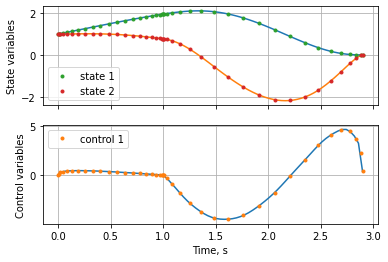

In [9]:
# ocp.du_continuity[0] = 1
mpo, post = mp.solve(ocp, n_segments=1, poly_orders=20, scheme="LGR", plot=True)

*Retrive the solution*

x: states, u: Controls, t:time, a:Algebraic variables

In [10]:
x, u, t, a = post.get_data()
print(f"Terminal time, state : {t[-1][0]:.4f} vs 2.9 (Exact), {x[-1]}")

Terminal time, state : 2.9000 vs 2.9 (Exact), [ 9.53605506e-12 -6.10348435e-12]


### Solve again with Chebyshev-Gauss-Lobatto (CGL) roots

Total number of variables............................:      125
                     variables with only lower bounds:       21
                variables with lower and upper bounds:       21
                     variables with only upper bounds:        0
Total number of equality constraints.................:       88
Total number of inequality constraints...............:       41
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       20
        inequality constraints with only upper bounds:       21


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   6.7496749138057129e-22    6.7496749138057129e-22
Dual infeasibility......:   5.0501516418909649e-11    5.0501516418909649e-11
Constraint violation....:   1.5804024755539103e-12    1.5804024755539103e-12
Complementarity.........:   2.5216728438899515e-09    2.5216728438899515e-09
Overall NLP er

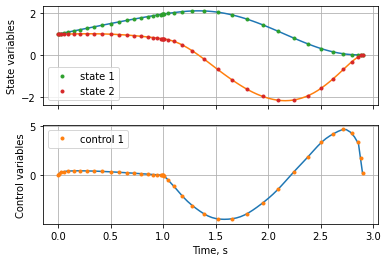

In [11]:
mpo, post = mp.solve(ocp, n_segments=1, poly_orders=20, scheme="CGL", plot=True)

In [12]:
x, u, t, a = post.get_data()
print(f"Terminal time, state : {t[-1][0]:.4f} vs 2.9s (Exact), {x[-1]}")

Terminal time, state : 2.9000 vs 2.9s (Exact), [ 9.78414149e-12 -6.26610513e-12]


### Solve again with Legendre-Gauss-Lobatto (LGL) roots

Total number of variables............................:      125
                     variables with only lower bounds:       21
                variables with lower and upper bounds:       21
                     variables with only upper bounds:        0
Total number of equality constraints.................:       88
Total number of inequality constraints...............:       41
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       20
        inequality constraints with only upper bounds:       21


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   6.7267963401089627e-22    6.7267963401089627e-22
Dual infeasibility......:   4.9171301510338480e-11    4.9171301510338480e-11
Constraint violation....:   1.5127898933542383e-12    1.5127898933542383e-12
Complementarity.........:   2.5210877471234159e-09    2.5210877471234159e-09
Overall NLP er

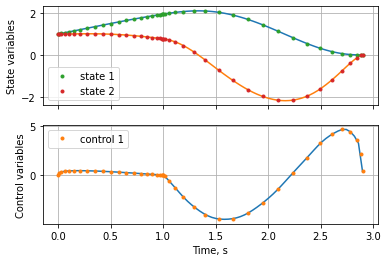

In [13]:
mpo, post = mp.solve(ocp, n_segments=1, poly_orders=20, scheme="LGL", plot=True)

In [14]:
x, u, t, a = post.get_data()
print(f"Terminal time, state : {t[-1][0]:.4f} vs 2.9s (Exact), {x[-1]}")

Terminal time, state : 2.9000 vs 2.9s (Exact), [ 9.76831449e-12 -6.25427524e-12]
